In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "eda_experiment"
RUN_NAME = "eda"

ASSETS_DIR = "assets"

if not os.path.exists(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [2]:
from dotenv import load_dotenv

load_dotenv() 

True

In [3]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(5) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,None,None,None,None,None,None,Female,0,No,No,No,0
1,21,8779-QRDMV,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,39.65,39.65,DSL,No,No,Yes,No,No,Yes,Male,1,No,No,None,1
2,22,1680-VDCWW,2019-02-01,NaT,One year,No,Bank transfer (automatic),19.80,202.25,None,None,None,None,None,None,None,Male,0,Yes,No,No,0
3,23,1066-JKSGK,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,None,None,None,None,None,None,None,Male,0,No,No,No,1
4,24,3638-WEABW,2015-04-01,NaT,Two year,Yes,Credit card (automatic),59.90,3505.10,DSL,No,Yes,No,Yes,No,No,Female,0,Yes,No,Yes,0


In [4]:
df['customer_id'].nunique()

7043

In [5]:
df['type'].nunique()

3

/tmp/ipykernel_49980/668383239.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0], hue=x, palette=sns.color_palette())
/tmp/ipykernel_49980/668383239.py:17: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0], hue=x, palette=sns.color_palette())
/tmp/ipykernel_49980/668383239.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);
/tmp/ipykernel_49980/668383239.py:26: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1], hue=x, palette=sns.color_palette())
/tmp/ipykernel_49980/668383239.py:33: UserWarning: The palette list has more values (10) than ne

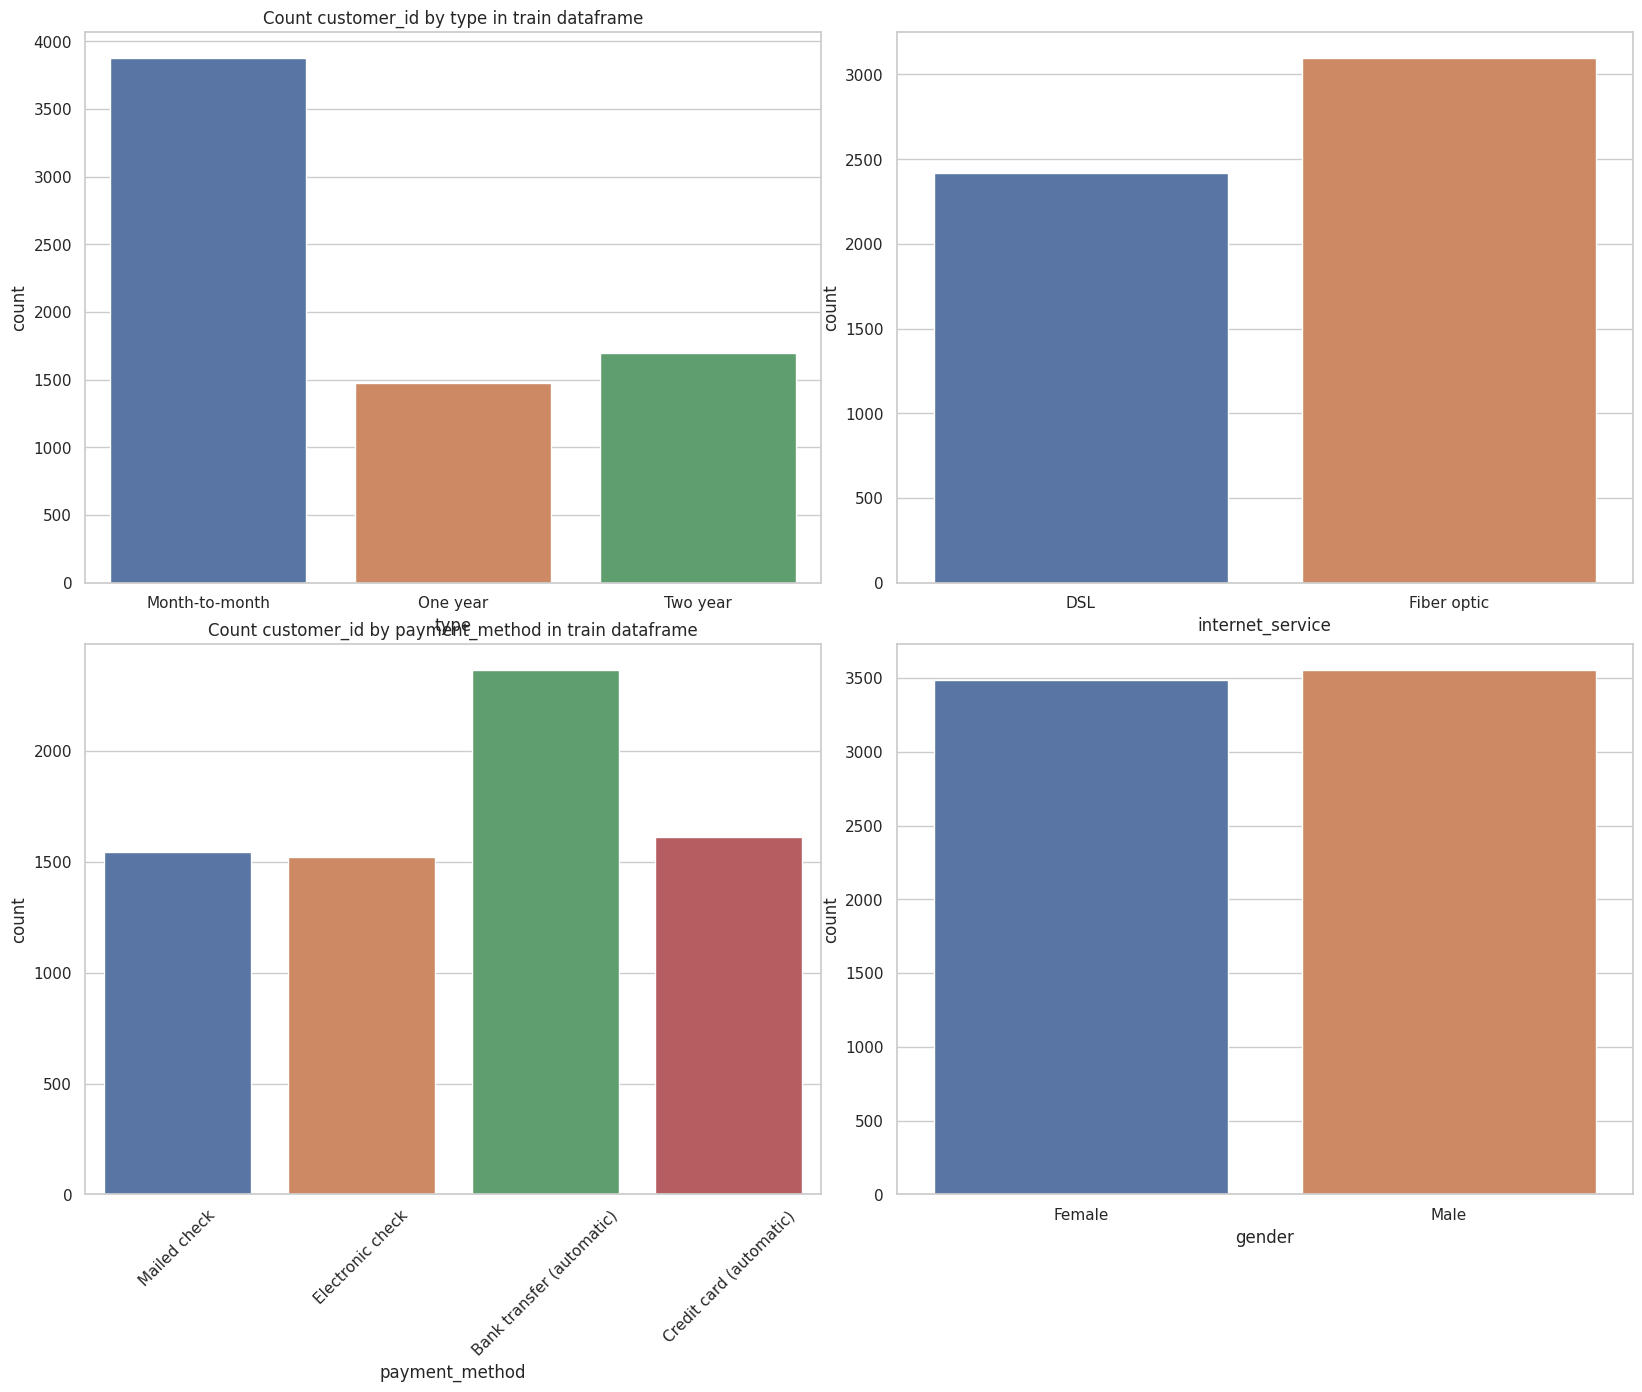

In [6]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0], hue=x, palette=sns.color_palette())
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0], hue=x, palette=sns.color_palette())

axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1], hue=x, palette=sns.color_palette())


x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1], hue=x, palette=sns.color_palette())

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

In [7]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count']

df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,No,No,No,No,No,No,0,No,No,371
106,No,Yes,No,No,No,No,0,No,No,105
414,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,Yes,103
4,No,No,No,No,No,No,1,No,No,101
8,No,No,No,No,No,Yes,0,No,No,90
15,No,No,No,No,Yes,No,0,No,No,86
214,Yes,No,No,No,No,No,0,No,No,83
22,No,No,No,No,Yes,Yes,0,No,No,82
413,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,No,75
3,No,No,No,No,No,No,0,Yes,Yes,68


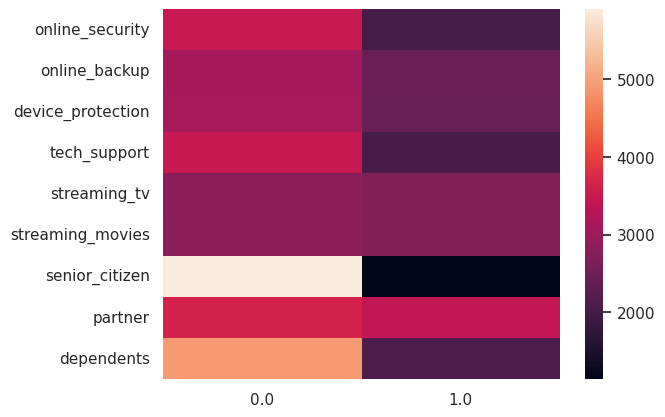

In [8]:
heat_df = df[binary_columns].replace({'Yes': 1, 'No': 0}).apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

In [9]:
heat_df

,0.0,1.0
online_security,3498,2019
online_backup,3088,2429
device_protection,3095,2422
tech_support,3473,2044
streaming_tv,2810,2707
streaming_movies,2785,2732
senior_citizen,5901,1142
partner,3641,3402
dependents,4933,2110


In [10]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# # переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

In [11]:
df.dropna(subset=charges_columns, inplace=True)
df[charges_columns].isna().sum()

monthly_charges    0
total_charges      0
dtype: int64

In [12]:
charges_monthly_agg

,begin_date,monthly_mean,monthly_median,monthly_mode
0,2013-10-01,104.800000,104.150,92.45
1,2013-11-01,108.325000,108.325,108.05
2,2013-12-01,91.066667,93.700,65.30
3,2014-01-01,95.864286,104.050,54.20
4,2014-02-01,80.934153,89.475,24.75
...,...,...,...,...
71,2019-09-01,59.490928,69.350,20.20
72,2019-10-01,56.259705,58.500,19.95
73,2019-11-01,54.602110,55.800,20.20
74,2019-12-01,52.312955,54.050,19.90


In [13]:
# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

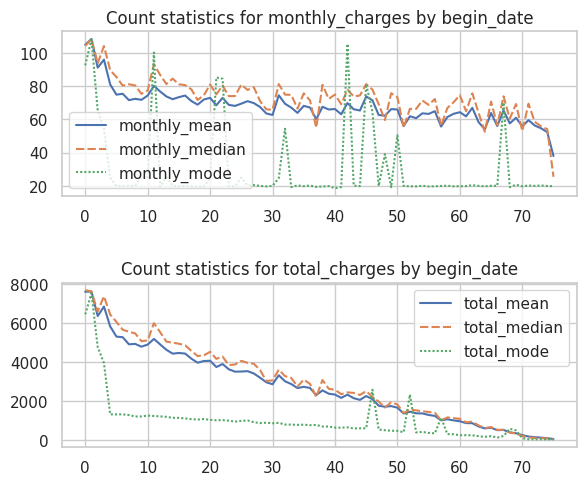

In [14]:
# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(data=charges_monthly_agg, ax=axs[0])
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

sns.lineplot(data=charges_total_agg, ax=axs[1])

# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

In [15]:
# директория для сохранения картинок
ASSETS_DIR = 'assets'

# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()

In [16]:
target_agg

,target,count
0,0,5163
1,1,1869


/tmp/ipykernel_49980/1378175989.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(target_agg, x='target', y='count', hue='target', palette=sns.color_palette())


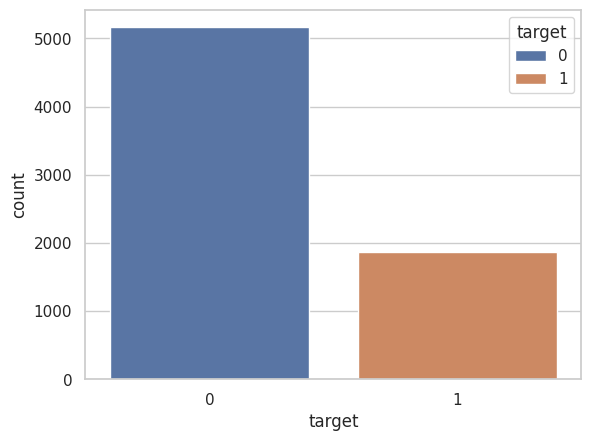

In [17]:
sns.barplot(target_agg, x='target', y='count', hue='target', palette=sns.color_palette())

plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

In [29]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
# target_agg_by_date = df.groupby(x).agg({ target: stat }).reset_index()
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]
target_agg_by_date.head(5)

,begin_date,target_count
0,2013-10-01,3
1,2013-11-01,2
2,2013-12-01,3
3,2014-01-01,7
4,2014-02-01,366


In [39]:
# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()
target_agg.head(5)

,begin_date,target,customer_id
0,2013-10-01,1,3
1,2013-11-01,1,2
2,2013-12-01,1,3
3,2014-01-01,1,7
4,2014-02-01,0,356


In [34]:
# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)
conversion_agg.head(5)

,begin_date,sum,count,conv
0,2013-10-01,3,3,1.00
1,2013-11-01,2,2,1.00
2,2013-12-01,3,3,1.00
3,2014-01-01,7,7,1.00
4,2014-02-01,10,366,0.03


In [35]:
# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender["conv"] = (conversion_agg['sum'] / conversion_agg['count']).round(2)
conversion_agg_gender.head(5)

,begin_date,gender,sum,count,conv
0,2013-10-01,Female,1,1,1.00
1,2013-10-01,Male,2,2,1.00
2,2013-11-01,Male,2,2,1.00
3,2013-12-01,Female,3,3,1.00
4,2014-01-01,Female,3,3,0.03


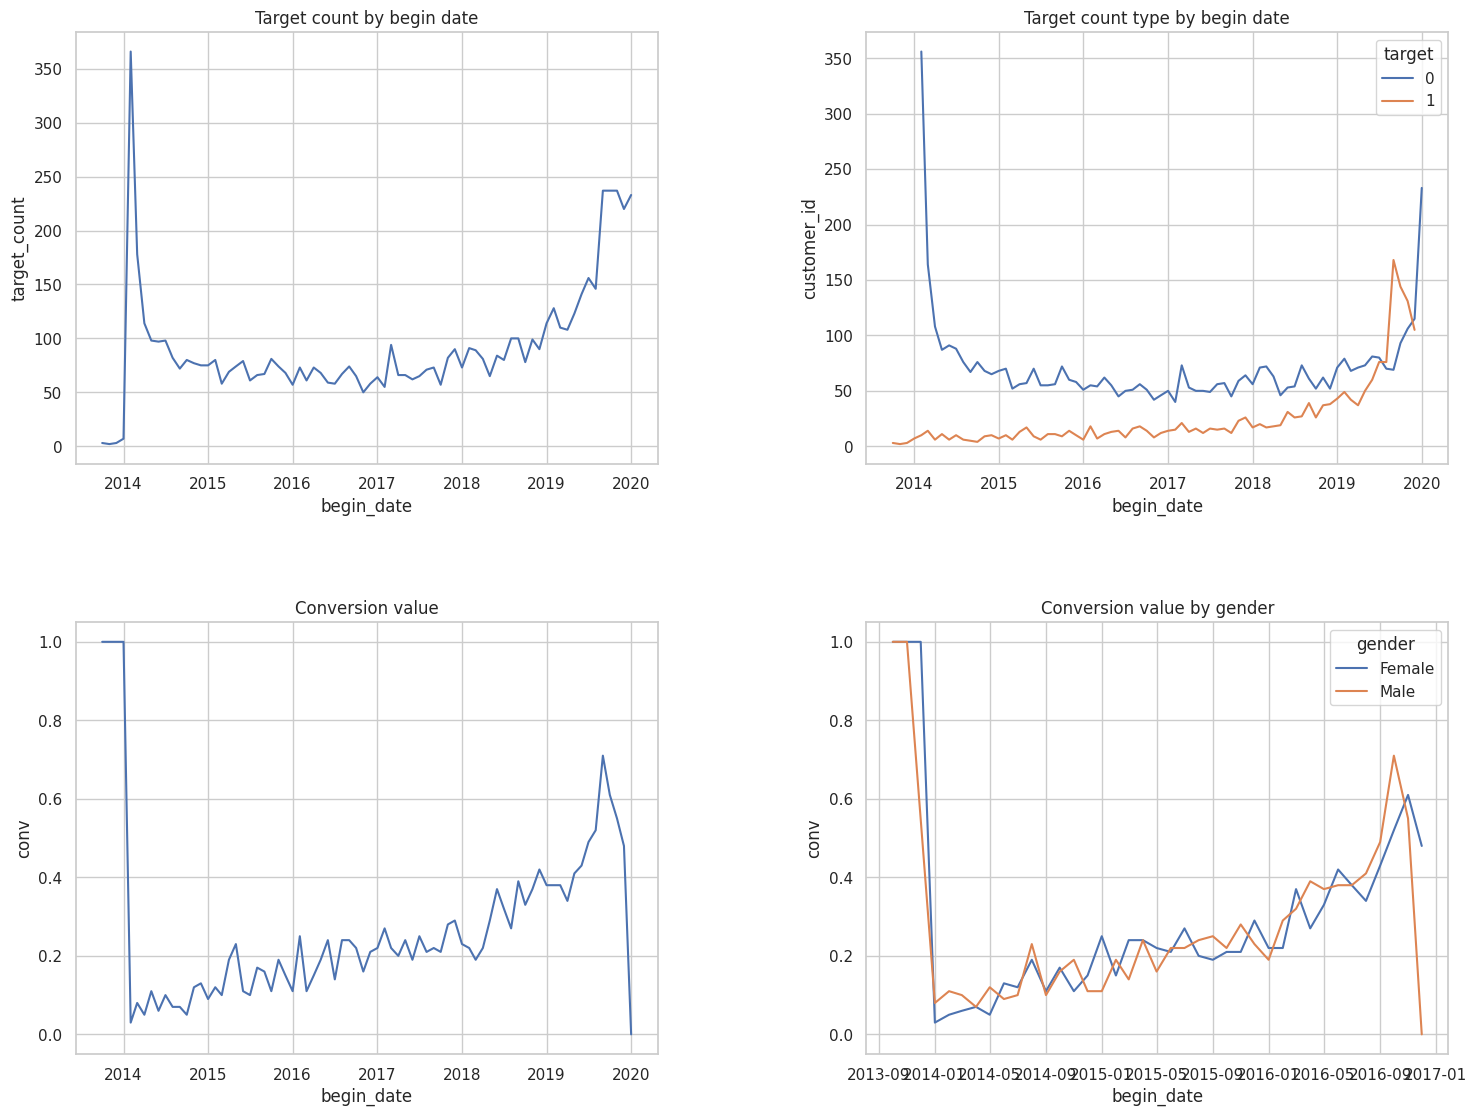

In [42]:
# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y='customer_id', hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y='conv', ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

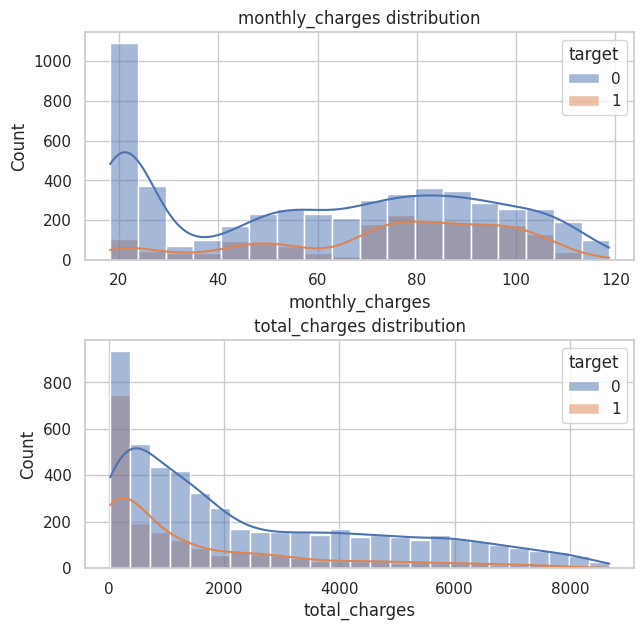

In [44]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
# датафрейм с данными
# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [46]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

if mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
else:
    experiment_id = mlflow.create_experiment(name=EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

In [47]:
run_id

'c78882ea2c17466ebe27472bd7789f31'